# Klasifikasi Gambar dengan Convolutional Neural Network (CNN)

Notebook ini mendemonstrasikan cara membangun dan melatih model **CNN** menggunakan ekosistem JAX modern:
*   **JAX**: Untuk komputasi performa tinggi.
*   **Flax NNX**: API terbaru untuk definisi model.
*   **Grain**: Library *data loading* yang cepat dan skalabel.

Kita akan melatih model CNN untuk mengenali kategori pakaian dari dataset **Fashion-MNIST**.

### Langkah 1: Persiapan Environment & Impor Library

In [1]:
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

from time import process_time
from IPython import display

import jax
import jax.numpy as jnp
from flax import nnx
import optax
import numpy as np
import grain.python as grain
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
import safetensors
from safetensors.flax import save_file, load_file

# Module lokal
import viz_utils as vu
from plot_lib import set_default
import train_utils as tu
from model_utils import save_checkpoint, load_checkpoint

import importlib
importlib.reload(vu)
importlib.reload(tu)

set_default()

### Langkah 2: Konfigurasi Parameter

In [2]:
DATA_DIR = "../data"
MODEL_DIR = "../models"
BATCH_SIZE = 128
LEARNING_RATE = 1e-3
EPOCHS = 5
SEED = 42

### Langkah 3: Memuat Dataset Fashion-MNIST

Kita menggunakan `scikit-learn` untuk mengunduh Fashion-MNIST dan mengemasnya dalam `FashionMNISTSource` yang kompatibel dengan **Grain**.

In [3]:
print("Memuat Fashion-MNIST via OpenML...")
fmnist = fetch_openml('Fashion-MNIST', version=1, as_frame=False, parser='liac-arff')
X_all, y_all = fmnist.data, fmnist.target.astype(np.int32)

# Split 60k / 10k
X_train, X_test = X_all[:60000], X_all[60000:]
y_train, y_test = y_all[:60000], y_all[60000:]

class FashionMNISTSource(grain.RandomAccessDataSource):
    def __init__(self, images, labels):
        self._images = images
        self._labels = labels
        
    def __len__(self):
        return len(self._images)
        
    def __getitem__(self, index):
        # Reshape ke (28, 28, 1) - format JAX standard (H, W, C)
        image = self._images[index].reshape(28, 28, 1).astype(np.float32) / 255.0
        label = self._labels[index]
        return {'image': image, 'label': label}

train_source = FashionMNISTSource(X_train, y_train)
test_source = FashionMNISTSource(X_test, y_test)
print(f"Train size: {len(train_source)}, Test size: {len(test_source)}")

num_classes = 10

Memuat Fashion-MNIST via OpenML...
Train size: 60000, Test size: 10000


### Langkah 4: Membangun Data Pipeline dengan Grain

In [4]:
def create_loader(source, batch_size, shuffle=True, seed=42):
    sampler = grain.IndexSampler(
        num_records=len(source),
        num_epochs=1,
        shard_options=grain.NoSharding(),
        shuffle=shuffle,
        seed=seed
    )
    
    loader = grain.DataLoader(
        data_source=source,
        sampler=sampler,
        worker_count=0, # Sync execution
    )

    # Convert record dictionaries to tuples for multi-assignment
    class BatchIterator:
        def __init__(self, loader, batch_size, num_records):
            self.loader = loader
            self.batch_size = batch_size
            self.num_records = num_records
        
        def __len__(self):
            return (self.num_records + self.batch_size - 1) // self.batch_size

        def __iter__(self):
            batch_images = []
            batch_labels = []
            for record in self.loader:
                batch_images.append(record['image'])
                batch_labels.append(record['label'])
                if len(batch_images) == self.batch_size:
                    yield np.stack(batch_images), np.array(batch_labels)
                    batch_images = []
                    batch_labels = []
            if batch_images:
                 yield np.stack(batch_images), np.array(batch_labels)
    
    return BatchIterator(loader, batch_size, len(source))

train_loader = create_loader(train_source, BATCH_SIZE, shuffle=True, seed=SEED)
test_loader = create_loader(test_source, BATCH_SIZE, shuffle=False)

# Peek the batched data
for ib, (X_batch, y_batch) in enumerate(train_loader):
    print(f"[{ib}] Shape of X [N, C, H, W]: {X_batch.shape}")
    print(f"[{ib}] Shape of y: {y_batch.shape}, {y_batch.dtype}")

[0] Shape of X [N, C, H, W]: (128, 28, 28, 1)
[0] Shape of y: (128,), int32
[1] Shape of X [N, C, H, W]: (128, 28, 28, 1)
[1] Shape of y: (128,), int32
[2] Shape of X [N, C, H, W]: (128, 28, 28, 1)
[2] Shape of y: (128,), int32
[3] Shape of X [N, C, H, W]: (128, 28, 28, 1)
[3] Shape of y: (128,), int32
[4] Shape of X [N, C, H, W]: (128, 28, 28, 1)
[4] Shape of y: (128,), int32
[5] Shape of X [N, C, H, W]: (128, 28, 28, 1)
[5] Shape of y: (128,), int32
[6] Shape of X [N, C, H, W]: (128, 28, 28, 1)
[6] Shape of y: (128,), int32
[7] Shape of X [N, C, H, W]: (128, 28, 28, 1)
[7] Shape of y: (128,), int32
[8] Shape of X [N, C, H, W]: (128, 28, 28, 1)
[8] Shape of y: (128,), int32
[9] Shape of X [N, C, H, W]: (128, 28, 28, 1)
[9] Shape of y: (128,), int32
[10] Shape of X [N, C, H, W]: (128, 28, 28, 1)
[10] Shape of y: (128,), int32
[11] Shape of X [N, C, H, W]: (128, 28, 28, 1)
[11] Shape of y: (128,), int32
[12] Shape of X [N, C, H, W]: (128, 28, 28, 1)
[12] Shape of y: (128,), int32
[13] S

### Langkah 5: Visualisasi Data

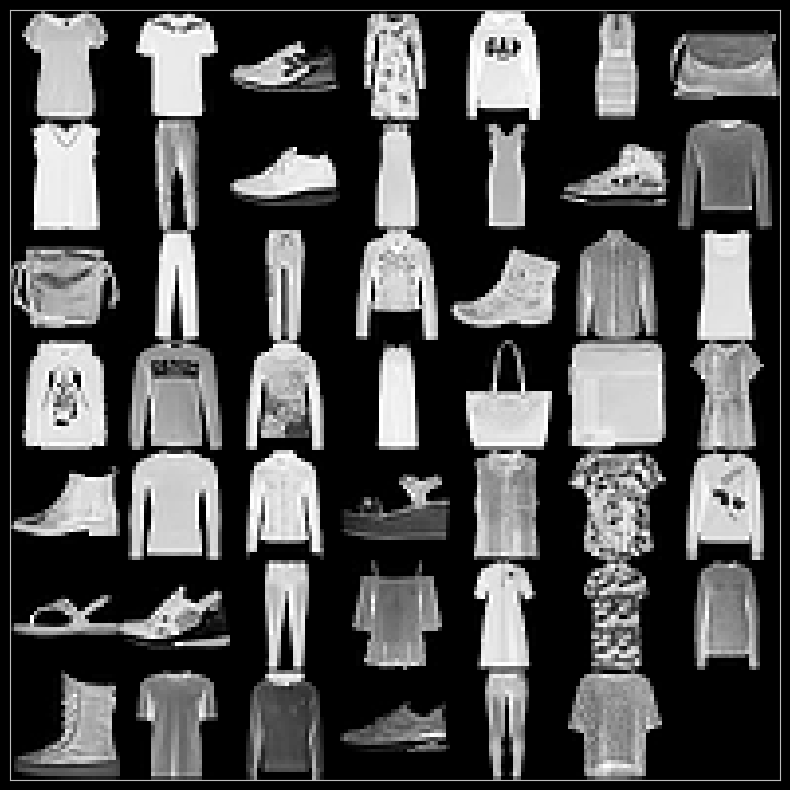

In [5]:
# Show training samples
grid = vu.set_grid(X_batch[:48], num_cells=48)
vu.show(grid)

### Langkah 6: Definisi Model CNN

Menggunakan `nnx.Conv` dan `nnx.Linear` untuk membangun arsitektur CNN sederhana.

In [6]:
class ConvNet(nnx.Module):
    def __init__(self, c_in, n_classes, rngs: nnx.Rngs):
        self.conv1 = nnx.Conv(c_in, 32, kernel_size=(3, 3), padding='SAME', rngs=rngs)
        self.conv2 = nnx.Conv(32, 64, kernel_size=(3, 3), padding='SAME', rngs=rngs)
        self.avg_pool = lambda x: jnp.mean(x, axis=(1, 2)) # Global Average Pooling
        self.linear = nnx.Linear(64, n_classes, rngs=rngs)
        
    def __call__(self, x):
        x = nnx.relu(self.conv1(x))
        x = nnx.max_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = nnx.relu(self.conv2(x))
        x = nnx.max_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = self.avg_pool(x)
        x = self.linear(x)
        return x

rngs = nnx.Rngs(SEED)
model = ConvNet(1, num_classes, rngs=rngs)
nnx.display(model)

### Langkah 7: Pelatihan Model

In [7]:
optimizer = nnx.Optimizer(model, optax.adam(LEARNING_RATE), wrt=nnx.Param)
metrics = nnx.MultiMetric(
    accuracy=nnx.metrics.Accuracy(),
    loss=nnx.metrics.Average(),
)

history = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': []}

checkpoint_dir = f"{MODEL_DIR}/conv2d_v2"

# create checkpoint directory if not exists
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

for epoch in range(EPOCHS):
    # Reset metrics for each epoch
    metrics.reset()
    
    # Train
    train_loss, train_time = tu.train(model, train_loader, optimizer, metrics)
    train_results = metrics.compute()
    history['train_loss'].append(train_results['loss'])
    history['train_acc'].append(train_results['accuracy'])
    
    # Evaluate
    metrics.reset()
    tu.evaluate(model, test_loader, metrics)
    test_results = metrics.compute()
    history['test_loss'].append(test_results['loss'])
    history['test_acc'].append(test_results['accuracy'])
    
    print(f"[Epoch {epoch+1}/{EPOCHS}] Train Acc: {train_results['accuracy']:.4f}, Test Acc: {test_results['accuracy']:.4f}")
    save_checkpoint(model, epoch + 1, filedir=f"{checkpoint_dir}")

100%|██████████| 79/79 [00:00<00:00, 115.96batch/s, loss=0.9061, time(secs)=1.94]


[Epoch 1/5] Train Acc: 0.5561, Test Acc: 0.6691
Model disimpan ke ../models/conv2d_v2/epoch_1.safetensors


100%|██████████| 79/79 [00:00<00:00, 112.00batch/s, loss=0.7144, time(secs)=1.94]


[Epoch 2/5] Train Acc: 0.7107, Test Acc: 0.7208
Model disimpan ke ../models/conv2d_v2/epoch_2.safetensors


100%|██████████| 79/79 [00:00<00:00, 108.26batch/s, loss=0.6641, time(secs)=1.96]


[Epoch 3/5] Train Acc: 0.7412, Test Acc: 0.7452
Model disimpan ke ../models/conv2d_v2/epoch_3.safetensors


100%|██████████| 79/79 [00:00<00:00, 109.37batch/s, loss=0.6485, time(secs)=1.95]


[Epoch 4/5] Train Acc: 0.7589, Test Acc: 0.7621
Model disimpan ke ../models/conv2d_v2/epoch_4.safetensors


100%|██████████| 79/79 [00:00<00:00, 110.12batch/s, loss=0.6435, time(secs)=1.93]

[Epoch 5/5] Train Acc: 0.7722, Test Acc: 0.7737
Model disimpan ke ../models/conv2d_v2/epoch_5.safetensors


### Langkah 8: Visualisasi Hasil Pelatihan

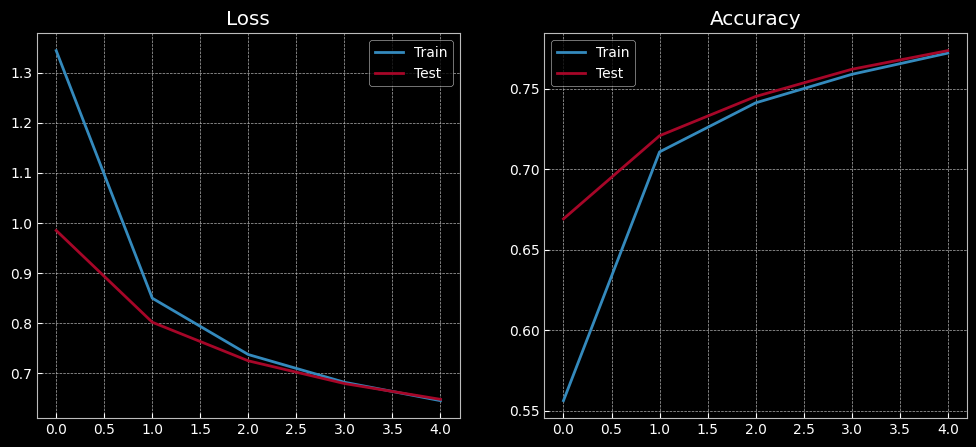

In [8]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train')
plt.plot(history['test_loss'], label='Test')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train')
plt.plot(history['test_acc'], label='Test')
plt.title('Accuracy')
plt.legend()
plt.show()

### Langkah 9: Menyimpan dan Memuat Model

Salah satu aspek penting dalam deep learning adalah kemampuan untuk menyimpan state model (parameter) sehingga kita tidak perlu melatih ulang dari awal. Kita menggunakan format `safetensors` dari Huggingfacekarena aman, efisien, dan cepat.

**Alasan Menggunakan Safetensors:**
1.  **Keamanan**: Tidak mengizinkan eksekusi kode saat memuat (berbeda dengan `pickle`).
2.  **Performa**: Mendukung *zero-copy* dan sangat cepat dalam proses I/O.
3.  **Interoperabilitas**: Kompatibel dengan berbagai framework (PyTorch, JAX, TensorFlow).

In [9]:
# Contoh Memuat Model yang Sudah Disimpan
# 1. Inisialisasi model baru dengan struktur yang sama
model_baru = ConvNet(1, num_classes, rngs=nnx.Rngs(SEED))

# 2. Muat parameter dari checkpoint epoch terakhir (misalnya epoch 5)
load_checkpoint(model_baru, f"{checkpoint_dir}/epoch_5.safetensors")

# 3. Verifikasi dengan melakukan inferensi pada satu batch
images, labels = next(iter(test_loader))
logits_orig = model(images)
logits_load = model_baru(images)

# Cek apakah hasilnya sama
diff = jnp.abs(logits_orig - logits_load).max()
print(f"Selisih maksimum output: {diff}")
if diff < 1e-5:
    print("Verifikasi Berhasil: Model yang dimuat memiliki output yang identik!")

Model dimuat dari ../models/conv2d_v2/epoch_5.safetensors
Selisih maksimum output: 0.0
Verifikasi Berhasil: Model yang dimuat memiliki output yang identik!
